## Objetivo:

O objetivo desta competição é desenvolver um modelo preditor do ELDT (Estimated Landing Time) para voos comerciais com origem e 
destino nos 12 principais aeródromos do Brasil, a saber:

- Brasília (SBBR)
- Confins (SBCF)
- Curitiba (SBCT)
- Florianópolis (SBFL)
- Rio de Janeiro - Galeão (SBGL)
- Guarulhos (SBGR)
- Campinas (SBKP)
- Porto Alegre (SBPA)
- Recife (SBRF)
- Rio de Janeiro - Santos Dumont (SBRJ)
- São Paulo - Congonhas (SBSP)
- Salvador (SBSV)

In [1]:
!pip install xgboost

import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import xgboost as xg

import requests
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')

random.seed(1)

print(f'tf_version: {tf.__version__}')


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
2023-09-19 05:45:48.740742: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-19 05:45:48.850888: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-09-19 05:45:48.850912: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-09-19 05:45:48.868825: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin

In [2]:
# Função para carregar os dados da API

def get_data_from_API(base_name, idate, fdate, token='a779d04f85c4bf6cfa586d30aaec57c44e9b7173'):
    ''' base_name (string): nome da base, opcões: bimtra, cat-62, esperas, metaf, metar, satelite, tc-prev, tc-real
        idate (string): data inicial
        fdate (string): data final
        token (string): chave de acesso na API já está defaltada
    ''' 


    url = 'http://montreal.icea.decea.mil.br:5002/api/v1/' + base_name
    params = {
    'token': token,
    'idate': idate,
    'fdate': fdate
}

    headers = {'accept': 'application/json'}

    response = requests.get(url, params=params, headers=headers)

    if response.status_code == 200:
        base = response.json()
        print(f"Base {base_name} carregada com sucesso!")
        return pd.DataFrame(base)
    else:
        print(f"A solicitação falhou com status code {response.status_code}")

In [3]:
# Setar datas para pegar dados da API
data_inicial = "2023-01-01"
data_final = "2023-02-01"

# Carregar o dataset BIMTRA

"""

A base de dados BIMTRA possui informações dos movimentos nos aeródromos do Brasil. Assim, é possível encontrar 
dados como hora de decolagem estimada, origem, destino, tempo de voo previsto, etc. Para o problema em questão, 
uma versão resumida do BIMTRA será fornecida, contendo os seguintes campos:

FlightID (Identificador único de um voo)
Origem (Código ICAO do Aeroporto de Origem do voo)
Destino (Código ICAO do Aeroporto de Destino do voo)
Hora_Dep (Data/Hora de Decolagem do voo)
Hora_Arr (Data/Hora de Pouso do voo)

O campo Hora_Arr corresponde ao atributo alvo do desafio proposto, isto é, o modelo desenvolvido por cada equipe 
deverá estimar os valores de Hora_Arr. Tomem cuidado com data leakage, ou seja, construindo modelos com informações do futuro.


"""


BIMTRA_df = get_data_from_API('bimtra', data_inicial, data_final)
display(BIMTRA_df)


Base bimtra carregada com sucesso!


,flightid,origem,destino,dt_dep,dt_arr
0,33ce5d33ca3414163a9a53b8ef481306,SBCF,SBKP,1672532479000,1672535819000
1,af199802cfa3ca88b4ed914d5d6eeac8,SBRJ,SBSP,1672531827000,1672534699000
2,a3c9ce921ea79926bd098837cabc0cdd,SBKP,SBPA,1672537722000,1672542680000
3,8d03bca2ee2d1def11cd7e8c5e5aa0ae,SBBR,SBCF,1672536591000,1672540037000
4,95093c33bb1c2c612ff0b56c65d05dbe,SBKP,SBGL,1672539714000,1672541937000
...,...,...,...,...,...
27384,783af9769d54638a2e50437558879fd0,SBCF,SBGR,1675258279000,1675261109000
27385,9b392363bc952a42e0e036eaeaaa37ea,SBBR,SBGR,1675260249000,1675264712000
27386,f9fad7a3ace67914c4e2a5033edb5782,SBCT,SBGR,1675255923000,1675258787000
27387,8b55f0da1f2bac4a17e5d48bac7c052b,SBCF,SBGR,1675288765000,1675292684000


In [4]:
esperas_df = get_data_from_API('esperas', data_inicial, data_final)
tc_prev_df = get_data_from_API('tc-prev', data_inicial, data_final)
tc_real_df = get_data_from_API('tc-real', data_inicial, data_final)

Base esperas carregada com sucesso!
Base tc-prev carregada com sucesso!
Base tc-real carregada com sucesso!


In [5]:
tc_prev_df.head()

,hora,troca,aero
0,1672531200000,0,BR
1,1672534800000,0,BR
2,1672538400000,0,BR
3,1672542000000,0,BR
4,1672545600000,0,BR


In [6]:
print(BIMTRA_df)
# Converter "dt_dep" e "dt_arr" para objetos de data e hora
# BIMTRA_df['dt_dep'] = pd.to_datetime(BIMTRA_df['dt_dep'], unit='ms')
# BIMTRA_df['dt_arr'] = pd.to_datetime(BIMTRA_df['dt_arr'], unit='ms')

                               flightid origem destino         dt_dep  \
0      33ce5d33ca3414163a9a53b8ef481306   SBCF    SBKP  1672532479000   
1      af199802cfa3ca88b4ed914d5d6eeac8   SBRJ    SBSP  1672531827000   
2      a3c9ce921ea79926bd098837cabc0cdd   SBKP    SBPA  1672537722000   
3      8d03bca2ee2d1def11cd7e8c5e5aa0ae   SBBR    SBCF  1672536591000   
4      95093c33bb1c2c612ff0b56c65d05dbe   SBKP    SBGL  1672539714000   
...                                 ...    ...     ...            ...   
27384  783af9769d54638a2e50437558879fd0   SBCF    SBGR  1675258279000   
27385  9b392363bc952a42e0e036eaeaaa37ea   SBBR    SBGR  1675260249000   
27386  f9fad7a3ace67914c4e2a5033edb5782   SBCT    SBGR  1675255923000   
27387  8b55f0da1f2bac4a17e5d48bac7c052b   SBCF    SBGR  1675288765000   
27388  3fe770905db2b15565d682007aad9120   SBRF    SBGR  1675256456000   

              dt_arr  
0      1672535819000  
1      1672534699000  
2      1672542680000  
3      1672540037000  
4      1

In [7]:
# Cálculo do ELDT 
# ELDT = (pd.to_datetime(BIMTRA_df.dt_arr) - pd.to_datetime(BIMTRA_df.dt_dep)).dt.total_seconds()
ELDT = BIMTRA_df['dt_arr'] - BIMTRA_df['dt_dep']
BIMTRA_df['eldt'] = ELDT
BIMTRA_df

,flightid,origem,destino,dt_dep,dt_arr,eldt
0,33ce5d33ca3414163a9a53b8ef481306,SBCF,SBKP,1672532479000,1672535819000,3340000
1,af199802cfa3ca88b4ed914d5d6eeac8,SBRJ,SBSP,1672531827000,1672534699000,2872000
2,a3c9ce921ea79926bd098837cabc0cdd,SBKP,SBPA,1672537722000,1672542680000,4958000
3,8d03bca2ee2d1def11cd7e8c5e5aa0ae,SBBR,SBCF,1672536591000,1672540037000,3446000
4,95093c33bb1c2c612ff0b56c65d05dbe,SBKP,SBGL,1672539714000,1672541937000,2223000
...,...,...,...,...,...,...
27384,783af9769d54638a2e50437558879fd0,SBCF,SBGR,1675258279000,1675261109000,2830000
27385,9b392363bc952a42e0e036eaeaaa37ea,SBBR,SBGR,1675260249000,1675264712000,4463000
27386,f9fad7a3ace67914c4e2a5033edb5782,SBCT,SBGR,1675255923000,1675258787000,2864000
27387,8b55f0da1f2bac4a17e5d48bac7c052b,SBCF,SBGR,1675288765000,1675292684000,3919000


In [8]:
display(BIMTRA_df.head())
display(BIMTRA_df.info())

,flightid,origem,destino,dt_dep,dt_arr,eldt
0,33ce5d33ca3414163a9a53b8ef481306,SBCF,SBKP,1672532479000,1672535819000,3340000
1,af199802cfa3ca88b4ed914d5d6eeac8,SBRJ,SBSP,1672531827000,1672534699000,2872000
2,a3c9ce921ea79926bd098837cabc0cdd,SBKP,SBPA,1672537722000,1672542680000,4958000
3,8d03bca2ee2d1def11cd7e8c5e5aa0ae,SBBR,SBCF,1672536591000,1672540037000,3446000
4,95093c33bb1c2c612ff0b56c65d05dbe,SBKP,SBGL,1672539714000,1672541937000,2223000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27389 entries, 0 to 27388
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   flightid  27389 non-null  object
 1   origem    27389 non-null  object
 2   destino   27389 non-null  object
 3   dt_dep    27389 non-null  int64 
 4   dt_arr    27389 non-null  int64 
 5   eldt      27389 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 1.3+ MB


None

# 1. Tratamento de Dados

## 1.1 Células vazias e duplicadas

In [9]:
# Checagem de células vazias
display(pd.DataFrame(BIMTRA_df.isnull().sum(), columns=['Nº Células Vazias']))

# Checagem de células duplicadas
print('Número de duplicatas: ', BIMTRA_df.duplicated().sum())
BIMTRA_df_adjusted = BIMTRA_df.drop_duplicates(inplace=False)

,Nº Células Vazias
flightid,0
origem,0
destino,0
dt_dep,0
dt_arr,0
eldt,0


Número de duplicatas:  267


In [10]:
print('Número de duplicatas após eliminação: ', BIMTRA_df_adjusted.duplicated().sum())

Número de duplicatas após eliminação:  0


In [11]:
# Checagem de células vazias
display(pd.DataFrame(tc_prev_df.isnull().sum(), columns=['Nº Células Vazias']))

# Checagem de células duplicadas
print('Número de duplicatas: ', tc_prev_df.duplicated().sum())
tc_prev_df_adjusted = tc_prev_df.drop_duplicates(inplace=False)

,Nº Células Vazias
hora,0
troca,0
aero,0


Número de duplicatas:  0


In [12]:
# Checagem de células vazias
display(pd.DataFrame(tc_real_df.isnull().sum(), columns=['Nº Células Vazias']))

# Checagem de células duplicadas
print('Número de duplicatas: ', tc_real_df.duplicated().sum())
tc_real_df_adjusted = tc_real_df.drop_duplicates(inplace=False)

,Nº Células Vazias
hora,0
nova_cabeceira,0
antiga_cabeceira,0
aero,0


Número de duplicatas:  0


## 1.2 Valores negativos

In [13]:
# Máscara booleana das linhas <= 0
mask = BIMTRA_df_adjusted['eldt'] <= 0

print('Número de linhas onde ELDT <= 0: ', BIMTRA_df_adjusted[mask].values.shape[0])
display(BIMTRA_df_adjusted[mask])

# Remove as linhas
BIMTRA_df_adjusted = BIMTRA_df_adjusted[~mask]

Número de linhas onde ELDT <= 0:  36


,flightid,origem,destino,dt_dep,dt_arr,eldt
2484,e82048177bf7703fd3f22425d9b1084f,SBRJ,SBFL,1672853315000,1672848993000,-4322000
4149,2b348d145754b8e9ac4de0469ed300fe,SBGR,SBFL,1673049307000,1672976477000,-72830000
7232,2d68d999f28e86f6154abc230129299d,SBSP,SBSV,1673266052000,1673262285000,-3767000
7942,da5697c4e136e01d1b236b84eb274c74,SBCF,SBRJ,1673347923000,1673345424000,-2499000
7946,45ebb4cfe8fa0f5f3d8f5526dc29af44,SBSP,SBRJ,1673348700000,1673345133000,-3567000
9938,6fef9d0d16cc5caf436d6b2e0252337b,SBFL,SBCF,1673520735000,1673512805000,-7930000
10575,90c4f6e70efbc6d27e4c91d74fca8e32,SBSP,SBRJ,1673652586000,1673568759000,-83827000
10623,160bb02f015c30491bf93a77c39f48ac,SBRJ,SBCT,1673652708000,1673569914000,-82794000
10794,5e3c31e3163c1b53d07a2e1eedc0f5bd,SBCT,SBRJ,1673651833000,1673569460000,-82373000
10879,5902b8ad90fa4c362f57f43fbfbc0972,SBRJ,SBBR,1673650148000,1673570008000,-80140000


## 1.3 Alterar colunas e juntar os dados

Mudar os dados da coluna "hora" para datetime. Assim, analisaremos melhor e será mais fácil para arredondar para um horario específico para o merge dos dataframes no futuro. Também vamos adicionar SB antes de todas as células da coluna "aero", para poder ficar igual a base BIMTRA.

In [14]:
# Previsão de mudança de cabeceiras
display(tc_prev_df.head())

,hora,troca,aero
0,1672531200000,0,BR
1,1672534800000,0,BR
2,1672538400000,0,BR
3,1672542000000,0,BR
4,1672545600000,0,BR


In [15]:
# Data e hora
tc_prev_df_adjusted['hora_tcp'] = pd.to_datetime(tc_prev_df['hora'], unit='ms')
tc_prev_df_adjusted.drop(['hora'], axis=1, inplace=True)

# Adicionar SB antes dos nomes na coluna aero 
tc_prev_df_adjusted['destino'] =  'SB' + tc_prev_df['aero']
tc_prev_df_adjusted.drop(['aero'], axis=1, inplace=True)

tc_prev_df_adjusted

,troca,hora_tcp,destino
0,0,2023-01-01 00:00:00,SBBR
1,0,2023-01-01 01:00:00,SBBR
2,0,2023-01-01 02:00:00,SBBR
3,0,2023-01-01 03:00:00,SBBR
4,0,2023-01-01 04:00:00,SBBR
...,...,...,...
9211,1,2023-02-01 19:00:00,SBSV
9212,0,2023-02-01 20:00:00,SBSV
9213,0,2023-02-01 21:00:00,SBSV
9214,1,2023-02-01 22:00:00,SBSV


Vamos juntar os dados da previsão da troca de cabeceiras com os dados BIMTRA, através hora após a decolagem e no aeroporto de destino especifico

In [16]:
# Criar coluna para ser usada para merge dos dataframes
BIMTRA_df_adjusted['hora_tcp'] = pd.to_datetime(BIMTRA_df_adjusted['dt_dep'], unit='ms')

# Fazer com que a data de saída seja apenas contendo o ano, mês, dia e hora (sem minutos ou segundos), assim como os dados do Kaggle
# Vamos arredondar as horas para cima com o método ceil passando o "H" de horas como parâmetro
BIMTRA_df_adjusted['hora_tcp'] = BIMTRA_df_adjusted['hora_tcp'].dt.ceil('H')

BIMTRA_tc = pd.merge(BIMTRA_df_adjusted, tc_prev_df_adjusted, on=['destino', 'hora_tcp'], how='left')

display(BIMTRA_tc)

,flightid,origem,destino,dt_dep,dt_arr,eldt,hora_tcp,troca
0,33ce5d33ca3414163a9a53b8ef481306,SBCF,SBKP,1672532479000,1672535819000,3340000,2023-01-01 01:00:00,0.0
1,af199802cfa3ca88b4ed914d5d6eeac8,SBRJ,SBSP,1672531827000,1672534699000,2872000,2023-01-01 01:00:00,0.0
2,a3c9ce921ea79926bd098837cabc0cdd,SBKP,SBPA,1672537722000,1672542680000,4958000,2023-01-01 02:00:00,0.0
3,8d03bca2ee2d1def11cd7e8c5e5aa0ae,SBBR,SBCF,1672536591000,1672540037000,3446000,2023-01-01 02:00:00,0.0
4,95093c33bb1c2c612ff0b56c65d05dbe,SBKP,SBGL,1672539714000,1672541937000,2223000,2023-01-01 03:00:00,0.0
...,...,...,...,...,...,...,...,...
27081,783af9769d54638a2e50437558879fd0,SBCF,SBGR,1675258279000,1675261109000,2830000,2023-02-01 14:00:00,1.0
27082,9b392363bc952a42e0e036eaeaaa37ea,SBBR,SBGR,1675260249000,1675264712000,4463000,2023-02-01 15:00:00,1.0
27083,f9fad7a3ace67914c4e2a5033edb5782,SBCT,SBGR,1675255923000,1675258787000,2864000,2023-02-01 13:00:00,1.0
27084,8b55f0da1f2bac4a17e5d48bac7c052b,SBCF,SBGR,1675288765000,1675292684000,3919000,2023-02-01 22:00:00,1.0


In [17]:
# Mudança de cabeceiras observadas
display(tc_real_df.head())

,hora,nova_cabeceira,antiga_cabeceira,aero
0,1672579592000,17,10,SV
1,1672579764000,10,17,SV
2,1672580077000,17R,12,SP
3,1672581279000,34,16,CF
4,1672581808000,33,15,KP


Fazer alterações similares as feitas ao dataset das previsões de trocas de cabeceiras. Entretando, este tem as trocas que realmente aconteceram (obeservadas). Ele possui colunas com informação sobre quais cabeceiras serão alteradas, as quais não iremos precisar para nosso modelo. Duplicatas irão surgir pois temos linhas com destino e hora repetidas por conta de diferentes cabeceiras trocadas para um determinado horário num determinado aeroporto. Assim, devemos excluí-las.

In [18]:
tc_real_to_merge = tc_real_df_adjusted.copy()

# Data e hora
tc_real_to_merge['hora_tcr'] = pd.to_datetime(tc_real_df['hora'], unit='ms')
tc_real_to_merge.drop(['hora'], axis=1, inplace=True)

tc_real_to_merge['hora_tcr'] = tc_real_to_merge['hora_tcr'].dt.floor('H')
print("Duplicatas após aproximação das horas:", tc_real_to_merge.duplicated().sum())

# Adicionar SB antes dos nomes na coluna aero 
tc_real_to_merge['destino'] =  'SB' + tc_real_to_merge['aero'].str[0:2]
tc_real_to_merge.drop(['aero'], axis=1, inplace=True)

# Dropar colunas "nova_cabeeceira" e "antiga_cabeceira"
tc_real_to_merge.drop(['nova_cabeceira', 'antiga_cabeceira'], axis=1, inplace=True)

print("Duplicatas após eliminação de colunas das cabeceiras:", tc_real_to_merge.duplicated().sum())

# Remover linhas duplicadas
tc_real_to_merge = tc_real_to_merge.drop_duplicates(inplace=False)

# Adicionar coluna de 1's para poder identificar quais vôos obtiveram a troca de cabeceiras após merge
tc_real_to_merge['troca_efetivada'] = 1

tc_real_to_merge

Duplicatas após aproximação das horas: 471
Duplicatas após eliminação de colunas das cabeceiras: 1336


,hora_tcr,destino,troca_efetivada
0,2023-01-01 13:00:00,SBSV,1
2,2023-01-01 13:00:00,SBSP,1
3,2023-01-01 13:00:00,SBCF,1
4,2023-01-01 14:00:00,SBKP,1
5,2023-01-01 14:00:00,SBFL,1
...,...,...,...
3185,2023-02-01 21:00:00,SBGR,1
3186,2023-02-01 22:00:00,SBFL,1
3187,2023-02-01 22:00:00,SBSP,1
3188,2023-02-01 22:00:00,SBPA,1


Os números das cabeceiras variam de 01 a 36, sempre com dois dígitos. Quando a cabeceira tem o número 27, significa que durante os pousos e decolagens a bússola marca 270°. No Santos Dumont, no Rio de Janeiro, os números são 02 e 20, enquanto Congonhas usa 17 e 35. Quando há duas pistas paralelas em um mesmo aeroporto, as cabeceiras têm os mesmos números, já que estão na mesma direção. Por conta disso, ganham as letras L ou R para diferenciar as pistas da esquerda (left) e da direita (right) na visão do piloto. Se houver três pistas paralelas, a central ganha a letra C (center).

Se, durante o voo, as condições meteorológicas ou outros fatores mudarem de tal forma que seja mais seguro ou eficiente usar uma pista de pouso diferente da planejada inicialmente, a torre de controle e a tripulação de voo podem tomar a decisão de trocar de cabeceira. Isso geralmente ocorre antes da aeronave se aproximar do aeroporto.

Juntar os dados da previsão das trocas de cabeceiras observadas com os demais

In [19]:
BIMTRA_cabeceiras = BIMTRA_tc.copy()

BIMTRA_cabeceiras['hora_tcr'] = pd.to_datetime(BIMTRA_tc['dt_dep'], unit='ms')

BIMTRA_cabeceiras['hora_tcr'] = BIMTRA_cabeceiras['hora_tcr'].dt.floor('H')

print(len(BIMTRA_cabeceiras))

# Realizar a concatenação dos dataframes
BIMTRA_cabeceiras = pd.merge(BIMTRA_cabeceiras, tc_real_to_merge, on=['destino', 'hora_tcr'], how='left')

BIMTRA_cabeceiras

27086


,flightid,origem,destino,dt_dep,dt_arr,eldt,hora_tcp,troca,hora_tcr,troca_efetivada
0,33ce5d33ca3414163a9a53b8ef481306,SBCF,SBKP,1672532479000,1672535819000,3340000,2023-01-01 01:00:00,0.0,2023-01-01 00:00:00,NaN
1,af199802cfa3ca88b4ed914d5d6eeac8,SBRJ,SBSP,1672531827000,1672534699000,2872000,2023-01-01 01:00:00,0.0,2023-01-01 00:00:00,NaN
2,a3c9ce921ea79926bd098837cabc0cdd,SBKP,SBPA,1672537722000,1672542680000,4958000,2023-01-01 02:00:00,0.0,2023-01-01 01:00:00,NaN
3,8d03bca2ee2d1def11cd7e8c5e5aa0ae,SBBR,SBCF,1672536591000,1672540037000,3446000,2023-01-01 02:00:00,0.0,2023-01-01 01:00:00,NaN
4,95093c33bb1c2c612ff0b56c65d05dbe,SBKP,SBGL,1672539714000,1672541937000,2223000,2023-01-01 03:00:00,0.0,2023-01-01 02:00:00,NaN
...,...,...,...,...,...,...,...,...,...,...
27081,783af9769d54638a2e50437558879fd0,SBCF,SBGR,1675258279000,1675261109000,2830000,2023-02-01 14:00:00,1.0,2023-02-01 13:00:00,1.0
27082,9b392363bc952a42e0e036eaeaaa37ea,SBBR,SBGR,1675260249000,1675264712000,4463000,2023-02-01 15:00:00,1.0,2023-02-01 14:00:00,NaN
27083,f9fad7a3ace67914c4e2a5033edb5782,SBCT,SBGR,1675255923000,1675258787000,2864000,2023-02-01 13:00:00,1.0,2023-02-01 12:00:00,NaN
27084,8b55f0da1f2bac4a17e5d48bac7c052b,SBCF,SBGR,1675288765000,1675292684000,3919000,2023-02-01 22:00:00,1.0,2023-02-01 21:00:00,1.0


In [20]:
num_trocas_observ = BIMTRA_cabeceiras['troca_efetivada'].count()
num_voos_diferentes = BIMTRA_cabeceiras['flightid'].nunique()
trocas_prev = BIMTRA_cabeceiras[BIMTRA_cabeceiras['troca']==1].count() 
num_trocas_prev = trocas_prev.iloc[0]
trocas_acertadas = len(BIMTRA_cabeceiras.loc[BIMTRA_cabeceiras['troca'] == BIMTRA_cabeceiras['troca_efetivada']])


print("Numero de voos com trocas observadas:", num_trocas_observ)
print("Numero de voos com trocas previstas:", num_trocas_prev)
print("Numero de voos com trocas previstas corretamente:", trocas_acertadas)

print("Numero de voos diferentes:", num_voos_diferentes)
print("Numero de voos duplicados:", BIMTRA_cabeceiras.flightid.duplicated().sum())

Numero de voos com trocas observadas: 6559
Numero de voos com trocas previstas: 10918
Numero de voos com trocas previstas corretamente: 3075
Numero de voos diferentes: 27086
Numero de voos duplicados: 0


# 2. EDA

Aparentemente nos casos em que o ELDT foi negativo, houve uma inversão entre origem e destino

In [22]:
BIMTRA_df_adjusted = BIMTRA_cabeceiras.copy()

Text(0.5, 1.0, 'ELDT')

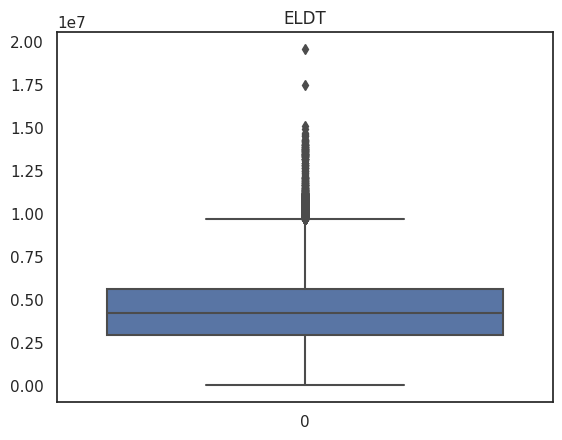

In [23]:
# Boxplot do ELDT
# fig = px.box(BIMTRA_df_adjusted['eldt'], title='ELDT', labels={'value': 'ELDT'}, points='outliers')
# fig.update_traces(dict(marker=dict(size=7,color="darkslategrey"),line=dict(width=1, color="darkslategrey")))
# fig.show()
sns.boxplot(BIMTRA_df_adjusted['eldt'], showfliers=True)

plt.title('ELDT')

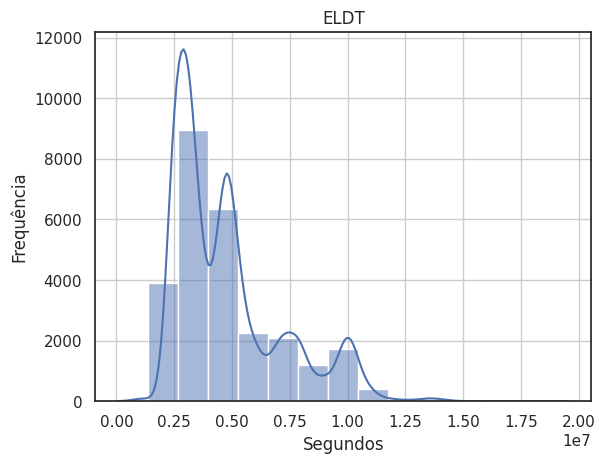

In [24]:
sns.histplot(BIMTRA_df_adjusted['eldt'], bins=15, kde = True)

plt.xlabel('Segundos')
plt.ylabel('Frequência')
plt.title('ELDT')
plt.grid(True)

# Exiba o histograma
plt.show()

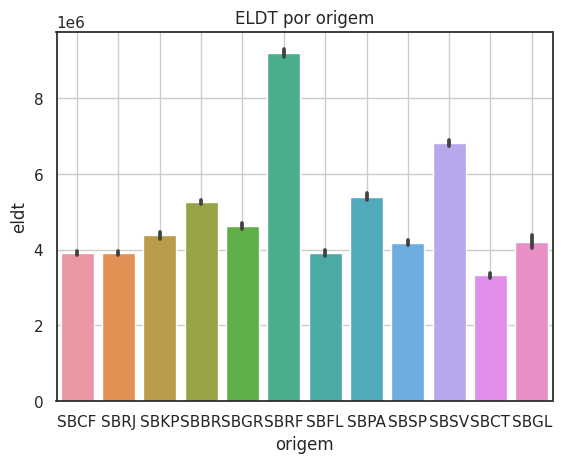

In [25]:
sns.barplot(x=BIMTRA_df_adjusted['origem'], y=BIMTRA_df_adjusted['eldt'])

plt.title('ELDT por origem')
plt.grid(True)

plt.show()

In [26]:
# Agrupar por origem e destino e calcular as estatísticas
impacto_aeroportos = BIMTRA_df_adjusted.groupby(['origem', 'destino']).agg({
    'flightid': 'count',              # Número total de voos
    'eldt': ['mean', 'min', 'max', 'std']  # Estatísticas de tempo de voo
}).reset_index()

# Renomear colunas para maior clareza
impacto_aeroportos.columns = ['Origem', 'Destino', 'Total_Voos', 'Tempo_Médio', 'Tempo_Mínimo', 'Tempo_Máximo', 'Desvio_Padrão']


display(impacto_aeroportos)

,Origem,Destino,Total_Voos,Tempo_Médio,Tempo_Mínimo,Tempo_Máximo,Desvio_Padrão
0,SBBR,SBCF,253,3.437735e+06,2340000,5351000,351912.198515
1,SBBR,SBCT,123,5.551016e+06,4999000,7148000,292907.415119
2,SBBR,SBFL,48,6.648042e+06,6020000,7864000,403515.243105
3,SBBR,SBGL,71,4.773592e+06,4400000,6307000,289565.565113
4,SBBR,SBGR,344,4.724863e+06,3434000,15094000,637190.902779
...,...,...,...,...,...,...,...
122,SBSV,SBKP,162,7.574315e+06,6811000,9608000,427890.078069
123,SBSV,SBPA,22,1.158959e+07,11010000,12466000,374015.489760
124,SBSV,SBRF,162,3.836969e+06,3360000,6515000,433825.757490
125,SBSV,SBRJ,204,6.778882e+06,5851000,10387000,545800.587813


# 3. Pré-processamento

In [27]:
BIMTRA_df_adjusted

,flightid,origem,destino,dt_dep,dt_arr,eldt,hora_tcp,troca,hora_tcr,troca_efetivada
0,33ce5d33ca3414163a9a53b8ef481306,SBCF,SBKP,1672532479000,1672535819000,3340000,2023-01-01 01:00:00,0.0,2023-01-01 00:00:00,NaN
1,af199802cfa3ca88b4ed914d5d6eeac8,SBRJ,SBSP,1672531827000,1672534699000,2872000,2023-01-01 01:00:00,0.0,2023-01-01 00:00:00,NaN
2,a3c9ce921ea79926bd098837cabc0cdd,SBKP,SBPA,1672537722000,1672542680000,4958000,2023-01-01 02:00:00,0.0,2023-01-01 01:00:00,NaN
3,8d03bca2ee2d1def11cd7e8c5e5aa0ae,SBBR,SBCF,1672536591000,1672540037000,3446000,2023-01-01 02:00:00,0.0,2023-01-01 01:00:00,NaN
4,95093c33bb1c2c612ff0b56c65d05dbe,SBKP,SBGL,1672539714000,1672541937000,2223000,2023-01-01 03:00:00,0.0,2023-01-01 02:00:00,NaN
...,...,...,...,...,...,...,...,...,...,...
27081,783af9769d54638a2e50437558879fd0,SBCF,SBGR,1675258279000,1675261109000,2830000,2023-02-01 14:00:00,1.0,2023-02-01 13:00:00,1.0
27082,9b392363bc952a42e0e036eaeaaa37ea,SBBR,SBGR,1675260249000,1675264712000,4463000,2023-02-01 15:00:00,1.0,2023-02-01 14:00:00,NaN
27083,f9fad7a3ace67914c4e2a5033edb5782,SBCT,SBGR,1675255923000,1675258787000,2864000,2023-02-01 13:00:00,1.0,2023-02-01 12:00:00,NaN
27084,8b55f0da1f2bac4a17e5d48bac7c052b,SBCF,SBGR,1675288765000,1675292684000,3919000,2023-02-01 22:00:00,1.0,2023-02-01 21:00:00,1.0


In [28]:
BIMTRA_df_encoded = BIMTRA_df_adjusted.copy()

# # One hot encoding das chegadas

# origem = BIMTRA_df_adjusted['origem'].unique()
# origem = pd.get_dummies(origem, prefix='origem')
# BIMTRA_df_encoded = BIMTRA_df_adjusted.join(origem)

# # One hot encoding dos destinos

# destino = BIMTRA_df_encoded['destino'].unique()
# destino = pd.get_dummies(destino, prefix='destino')
# BIMTRA_df_encoded = BIMTRA_df_encoded.join(destino)
# BIMTRA_df_encoded

# BIMTRA_df_encoded.drop(['origem', 'destino'], axis=1, inplace=True)

# Organizando a ordem das colunas
l = list(BIMTRA_df_encoded.columns)
l.remove('eldt')
l.remove('flightid')
l.remove('dt_arr')
l.remove('hora_tcp')
l.remove('hora_tcr')
l.remove('troca_efetivada')
l.append('eldt')

BIMTRA_df_encoded = BIMTRA_df_encoded[l]

# Converte variáveis categoricas para o tipo "category" (Requisito pro XGBoost funcionar)
BIMTRA_df_encoded['origem'] = BIMTRA_df_encoded['origem'].astype('category')
BIMTRA_df_encoded['destino'] = BIMTRA_df_encoded['destino'].astype('category')
BIMTRA_df_encoded

,origem,destino,dt_dep,troca,eldt
0,SBCF,SBKP,1672532479000,0.0,3340000
1,SBRJ,SBSP,1672531827000,0.0,2872000
2,SBKP,SBPA,1672537722000,0.0,4958000
3,SBBR,SBCF,1672536591000,0.0,3446000
4,SBKP,SBGL,1672539714000,0.0,2223000
...,...,...,...,...,...
27081,SBCF,SBGR,1675258279000,1.0,2830000
27082,SBBR,SBGR,1675260249000,1.0,4463000
27083,SBCT,SBGR,1675255923000,1.0,2864000
27084,SBCF,SBGR,1675288765000,1.0,3919000


# 4. Treinamento 

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(BIMTRA_df_encoded.copy().drop('eldt', axis=1), BIMTRA_df_encoded['eldt'], test_size=0.2)

In [30]:
reg = xg.XGBRegressor(enable_categorical=True)
reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## 4.1 Performance do modelo

In [31]:
print("Performance do modelo nos dados de treino: ", str(round(reg.score(X_train, y_train) * 100, 2))+"%")
print("Performance do modelo nos dados de teste: ", str(round(reg.score(X_test, y_test) * 100, 2))+"%")

Performance do modelo nos dados de treino:  98.17%
Performance do modelo nos dados de teste:  97.25%


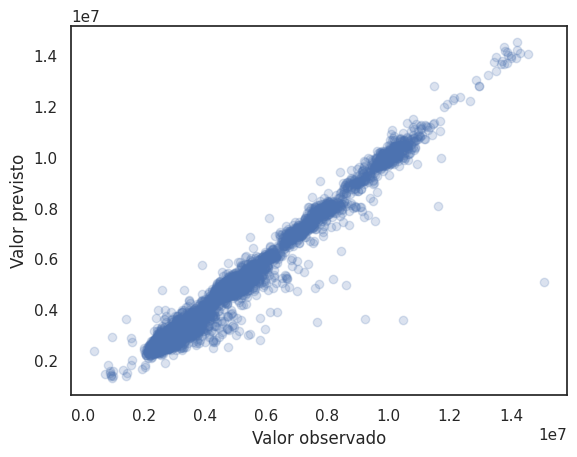

In [32]:
# Previsão
y_pred = reg.predict(X_test)

plt.scatter(y_test, y_pred, alpha=0.2)
plt.xlabel('Valor observado')
plt.ylabel('Valor previsto')
plt.show()

# fig = px.scatter(x=y_test, y=y_pred)
# fig.update_xaxes(title="Valor observado")
# fig.update_yaxes(title="Valor previsto")

# # Add a title
# fig.update_layout(title="Valor observado vs. Valor previsto")


In [33]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("Erro Quadrático Médio (MSE): ", mean_squared_error(y_test, y_pred))
print("Erro Absoluto Médio (MAE): ", mean_absolute_error(y_test, y_pred))
print("Raiz do Erro Quadrático Médio (RMSE) : ", np.sqrt(mean_squared_error(y_test, y_pred)))

print("R2: ", r2_score(y_test, y_pred))

Erro Quadrático Médio (MSE):  153167478205.68643
Erro Absoluto Médio (MAE):  222594.16403654485
Raiz do Erro Quadrático Médio (RMSE) :  391366.1689590535
R2:  0.9725489791621056


# 5. Submissão

In [34]:
# Csv de teste do Kaggle
idsc_test = pd.read_csv('idsc_test.csv')
idsc_test

,flightid,origem,destino,dt_dep,hora_ref,snapshot_radar,path,hora_esperas,esperas,aero_esperas,...,metaf,aero_metaf,hora_metar,metar,aero_metar,hora_tcp,troca,aero_tcp,hora_tcr,aero_tcr
0,7945735584a3297121c4f5ae0de8ecd1,SBKP,SBSV,2023-05-30 11:36:03.000,2023-05-30 11:00:00.000,MULTIPOINT ((-0.8807200448127578 -0.5148453155...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-30 10:00:00.000,0,SBSV,...,NaN,NaN,2023-05-30 11:00:00.000,METAR SBSV 301100Z 12009KT 9999 FEW023 28/21 Q...,SBSV,2023-05-30 12:00:00.000,0,SBSV,NaN,NaN
1,85cb958e8b9d583575cd9cb93e389226,SBFL,SBRJ,2023-05-19 08:26:06.000,2023-05-19 08:00:00.000,MULTIPOINT ((-0.8826266039383116 -0.4926305156...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-19 07:00:00.000,0,SBRJ,...,METAF SBRJ 190900Z 33004KT 9999 BKN033 ...,SBRJ,2023-05-19 08:00:00.000,METAR SBRJ 190800Z 02004KT 9999 FEW010 SCT040 ...,SBRJ,2023-05-19 09:00:00.000,0,SBRJ,NaN,NaN
2,2d4e8cd3947525a12ff16af520beefb9,SBCF,SBGR,2023-05-22 11:52:02.000,2023-05-22 11:00:00.000,MULTIPOINT ((-0.8972512464147154 -0.5215196550...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-22 10:00:00.000,0,SBGR,...,METAF SBGR 221200Z 04003KT CAVOK 19/09 Q1021=\n,SBGR,2023-05-22 11:00:00.000,METAR SBGR 221100Z 07006KT CAVOK 13/12 Q1022=,SBGR,2023-05-22 12:00:00.000,0,SBGR,NaN,NaN
3,24cf317a1494a016a018d9f5cd183639,SBFL,SBSP,2023-05-29 16:07:07.000,2023-05-29 16:00:00.000,MULTIPOINT ((-0.892972783728755 -0.51704889771...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-29 15:00:00.000,2,SBSP,...,METAF SBSP 291700Z 15010KT 9999 OVC033 ...,SBSP,2023-05-29 16:00:00.000,METAR SBSP 291600Z 12010KT 090V160 9999 SCT015...,SBSP,2023-05-29 17:00:00.000,0,SBSP,NaN,NaN
4,370babaf32dc82a6a64bf5b71a3434ed,SBCF,SBKP,2023-05-25 22:16:04.000,2023-05-25 22:00:00.000,MULTIPOINT ((-0.8970045369724385 -0.5240544927...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-25 21:00:00.000,0,SBKP,...,METAF SBKP 252300Z 08008KT CAVOK 21/12 Q1019=\n,SBKP,2023-05-25 22:00:00.000,METAR SBKP 252200Z 09004KT CAVOK 23/13 Q1020=,SBKP,2023-05-25 23:00:00.000,0,SBKP,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,6f6d576aafbd90e308a848a060395e9a,SBPA,SBGR,2023-05-19 22:02:03.000,2023-05-19 22:00:00.000,MULTIPOINT ((-0.8891070333352145 -0.5128856751...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-19 21:00:00.000,0,SBGR,...,METAF SBGR 192300Z 11006KT 9000 FEW019 ...,SBGR,2023-05-19 22:00:00.000,METAR SBGR 192200Z 14003KT CAVOK 16/13 Q1021=,SBGR,2023-05-19 23:00:00.000,0,SBGR,NaN,NaN
96,20055ed6ecea5e916923081fc3b049f7,SBCF,SBKP,2023-05-31 19:54:04.000,2023-05-31 19:00:00.000,MULTIPOINT ((-0.8887839089364267 -0.5156303040...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-31 18:00:00.000,0,SBKP,...,METAF SBKP 312000Z 23006KT 9999 OVC022 ...,SBKP,2023-05-31 19:00:00.000,METAR SBKP 311900Z 24005KT 5000 2000S -RA BR B...,SBKP,2023-05-31 20:00:00.000,0,SBKP,2023-05-31 19:00:00.000,SBKP
97,c5e4e8d78906ae2b3218847cc9f045d9,SBSP,SBRJ,2023-05-20 15:16:05.000,2023-05-20 15:00:00.000,MULTIPOINT ((-0.8916331377478003 -0.5089690765...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-20 14:00:00.000,0,SBRJ,...,METAF SBRJ 201600Z 10003KT 9999 FEW033 ...,SBRJ,2023-05-20 15:00:00.000,METAR SBRJ 201500Z 34003KT 250V040 CAVOK 23/16...,SBRJ,2023-05-20 16:00:00.000,0,SBRJ,NaN,NaN
98,878ad3e9104c78f2945f6194c2d883ce,SBBR,SBSP,2023-05-31 11:31:02.000,2023-05-31 11:00:00.000,MULTIPOINT ((-0.8987280459174578 -0.5209708603...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-31 10:00:00.000,0,SBSP,...,METAF SBSP 311200Z 07006KT 6000 - RA OVC026 ...,SBSP,2023-05-31 11:00:00.000,METAR SBSP 311100Z 08006KT 020V120 4000 -RA BR...,SBSP,2023-05-31 12:00:00.000,0,SBSP,NaN,NaN


In [35]:
idsc_test_encoded = idsc_test.copy()

# Organizando as colunas
l = list(idsc_test_encoded.columns)
l.remove('flightid')
idsc_test_encoded = idsc_test_encoded[l]

filtro = pd.Series(idsc_test_encoded.columns)
filtro = filtro[filtro.isin(BIMTRA_df_encoded.columns)]
idsc_test_encoded = idsc_test_encoded[filtro]

# Converte data e hora para o tipo milissegundos desde 1970
idsc_test_encoded['dt_dep'] = pd.to_datetime(idsc_test_encoded['dt_dep'], format='%Y-%m-%d %H:%M:%S.%f')
idsc_test_encoded['dt_dep'] = (idsc_test_encoded['dt_dep'].astype(int) / 10**6) #.astype('datetime64[ms]')

# Converte variáveis categoricas para o tipo "category" (Requisito pro XGBoost funcionar)
idsc_test_encoded['origem'] = idsc_test_encoded['origem'].astype('category')
idsc_test_encoded['destino'] = idsc_test_encoded['destino'].astype('category')

idsc_test_encoded

,origem,destino,dt_dep,troca
0,SBKP,SBSV,1.685447e+12,0
1,SBFL,SBRJ,1.684485e+12,0
2,SBCF,SBGR,1.684756e+12,0
3,SBFL,SBSP,1.685376e+12,0
4,SBCF,SBKP,1.685053e+12,0
...,...,...,...,...
95,SBPA,SBGR,1.684534e+12,0
96,SBCF,SBKP,1.685563e+12,0
97,SBSP,SBRJ,1.684596e+12,0
98,SBBR,SBSP,1.685533e+12,0


In [36]:
# Prediz os valores
y_pred = reg.predict(idsc_test_encoded)
data_in_seconds = y_pred / 1000.0

# Criar um DataFrame com a coluna de dados em segundos
y_pred = pd.DataFrame(data_in_seconds)

y_pred

,0
0,7279.161621
1,4409.333008
2,3511.659912
3,3361.883301
4,3074.244629
...,...
95,5352.867188
96,3074.244629
97,2740.223145
98,5170.933105


In [37]:
sumbission = pd.DataFrame()
sumbission['ID'] = idsc_test['flightid']
sumbission['solution'] = y_pred

sumbission.to_csv('submission.csv', index=False)

In [38]:
sumbission

,ID,solution
0,7945735584a3297121c4f5ae0de8ecd1,7279.161621
1,85cb958e8b9d583575cd9cb93e389226,4409.333008
2,2d4e8cd3947525a12ff16af520beefb9,3511.659912
3,24cf317a1494a016a018d9f5cd183639,3361.883301
4,370babaf32dc82a6a64bf5b71a3434ed,3074.244629
...,...,...
95,6f6d576aafbd90e308a848a060395e9a,5352.867188
96,20055ed6ecea5e916923081fc3b049f7,3074.244629
97,c5e4e8d78906ae2b3218847cc9f045d9,2740.223145
98,878ad3e9104c78f2945f6194c2d883ce,5170.933105


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4ef28bfa-f18c-417e-93b5-8e27cf9bc92e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>